In [1]:
!pip install torch_geometric

In [5]:
import math
import torch
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.data import Data
import random

def verify_data_correctness(data, min_energy_threshold, competence_diff_threshold,
                           max_distance_threshold, threshold_combiner):
    """Проверяет, что все метки следуют правилам"""
    print(f"\nПроверка корректности данных")

    x = data.x
    edge_index = data.edge_label_index
    edge_labels = data.edge_label

    pos_indices = (edge_labels == 1.0).nonzero(as_tuple=True)[0]
    violations = 0

    for idx in pos_indices[:100]:  # Проверим первые 100 для скорости
        u, v = edge_index[0, idx].item(), edge_index[1, idx].item()
        energy_u, comp_u, loc_x_u, loc_y_u = x[u]
        energy_v, comp_v, loc_x_v, loc_y_v = x[v]

        # Проверяем условия
        cond_energy = (energy_u > min_energy_threshold) and (energy_v > min_energy_threshold)
        cond_competence = abs(comp_u - comp_v) < competence_diff_threshold
        distance = math.sqrt((loc_x_u - loc_x_v)**2 + (loc_y_u - loc_y_v)**2)
        cond_distance = distance < max_distance_threshold

        # Проверяем в зависимости от комбинатора
        if threshold_combiner == 'and':
            should_be_positive = cond_energy and cond_competence and cond_distance
        else:
            should_be_positive = cond_energy or cond_competence or cond_distance

        if not should_be_positive:
            violations += 1

    print(f"Проверено положительных меток: {len(pos_indices[:100])}")
    print(f"Нарушений правил: {violations}")

    if violations == 0:
        print("ВСЕ метки корректны!")
    else:
        print(f"Найдены нарушения: {violations} ({violations/len(pos_indices[:100]):.1%})")

def generate_correct_balanced_data_fixed(
    num_graphs=500,
    min_nodes=5,
    max_nodes=20,
    target_positive_ratio=0.3,
    adaptive_threshold=True,
    random_seed=42
):
    if random_seed is not None:
        random.seed(random_seed)
        torch.manual_seed(random_seed)

    data_list = []
    total_stats = {'positive': 0, 'negative': 0}

    if adaptive_threshold:
        if target_positive_ratio >= 0.35:
            min_energy_threshold = 0.3
            competence_diff_threshold = 0.6
            max_distance_threshold = 14.0
        elif target_positive_ratio >= 0.30:
            min_energy_threshold = 0.45
            competence_diff_threshold = 0.45
            max_distance_threshold = 11.0
        elif target_positive_ratio >= 0.25:
            min_energy_threshold = 0.5
            competence_diff_threshold = 0.4
            max_distance_threshold = 10.0
        elif target_positive_ratio >= 0.20:
            min_energy_threshold = 0.55
            competence_diff_threshold = 0.35
            max_distance_threshold = 9.0
        else:
            min_energy_threshold = 0.6
            competence_diff_threshold = 0.3
            max_distance_threshold = 8.0

        print(f"Адаптированные пороги для {target_positive_ratio:.0%} положительных")
        print(f"  min_energy_threshold {min_energy_threshold}")
        print(f"  competence_diff_threshold {competence_diff_threshold}")
        print(f"  max_distance_threshold {max_distance_threshold}")
        print(f"  threshold_combiner 'and'")

    for i in range(num_graphs):
        num_nodes = random.randint(min_nodes, max_nodes)

        if target_positive_ratio >= 0.3:
            high_energy_prob = 0.65
        elif target_positive_ratio >= 0.25:
            high_energy_prob = 0.6
        else:
            high_energy_prob = 0.5

        x = torch.zeros((num_nodes, 4), dtype=torch.float)

        for j in range(num_nodes):
            if random.random() < high_energy_prob:
                x[j, 0] = random.uniform(min_energy_threshold + 0.05, 1.0)
            else:
                x[j, 0] = random.uniform(0.0, min_energy_threshold - 0.05)

        num_clusters = 2
        base_center = random.uniform(0.3, 0.7)
        if target_positive_ratio >= 0.3:
            cluster_centers = [base_center - 0.15, base_center + 0.15]
        else:
            cluster_centers = [base_center - 0.1, base_center + 0.1]

        cluster_assignments = [random.randint(0, num_clusters-1) for _ in range(num_nodes)]

        for j in range(num_nodes):
            cluster_idx = cluster_assignments[j]
            center = cluster_centers[cluster_idx]
            spread = 0.12 if target_positive_ratio >= 0.3 else 0.15
            x[j, 1] = random.uniform(center - spread, center + spread)
            x[j, 1] = max(0.0, min(1.0, x[j, 1]))

        center_x = random.uniform(-5, 5)
        center_y = random.uniform(-5, 5)

        if target_positive_ratio >= 0.3:
            spread = max_distance_threshold * 0.35
        else:
            spread = max_distance_threshold * 0.4

        for j in range(num_nodes):
            x[j, 2] = random.uniform(center_x - spread, center_x + spread)
            x[j, 3] = random.uniform(center_y - spread, center_y + spread)

        edge_index_input_list = []
        edge_index_label_list = []
        edge_label_list = []

        for u in range(num_nodes):
            for v in range(num_nodes):
                if u != v:
                    edge_index_input_list.append([u, v])

        for u in range(num_nodes):
            for v in range(u + 1, num_nodes):
                energy_u, comp_u, loc_x_u, loc_y_u = x[u]
                energy_v, comp_v, loc_x_v, loc_y_v = x[v]

                cond_energy = (energy_u > min_energy_threshold) and (energy_v > min_energy_threshold)
                cond_competence = abs(comp_u - comp_v) < competence_diff_threshold
                distance = math.sqrt((loc_x_u - loc_x_v)**2 + (loc_y_u - loc_y_v)**2)
                cond_distance = distance < max_distance_threshold

                label_val = 1.0 if (cond_energy and cond_competence and cond_distance) else 0.0

                edge_index_label_list.append([u, v])
                edge_index_label_list.append([v, u])
                edge_label_list.append(label_val)
                edge_label_list.append(label_val)

                if label_val == 1.0:
                    total_stats['positive'] += 2
                else:
                    total_stats['negative'] += 2

        edge_index_input = torch.tensor(edge_index_input_list, dtype=torch.long).t().contiguous()
        edge_index_label = torch.tensor(edge_index_label_list, dtype=torch.long).t().contiguous()
        edge_label = torch.tensor(edge_label_list, dtype=torch.float)

        data = Data(
            x=x,
            edge_index=edge_index_input,
            edge_label_index=edge_index_label,
            edge_label=edge_label
        )
        data_list.append(data)

    total = total_stats['positive'] + total_stats['negative']
    pos_ratio = total_stats['positive'] / total if total > 0 else 0

    print(f"\nРезультаты генерации")
    print(f"Сгенерировано графов {len(data_list)}")
    print(f"Всего меток {total}")
    print(f"Положительных {total_stats['positive']} ({pos_ratio:.2%})")
    print(f"Отрицательных {total_stats['negative']} ({1-pos_ratio:.2%})")
    print(f"Целевой баланс {target_positive_ratio:.2%}")
    print(f"Отклонение {abs(pos_ratio - target_positive_ratio):.2%}")

    if len(data_list) > 0:
        verify_data_correctness(data_list[0], min_energy_threshold,
                              competence_diff_threshold, max_distance_threshold,
                              'and')

    return data_list

print("Тесть для 30%")
synthetic_data_30_fixed = generate_correct_balanced_data_fixed(
    num_graphs=500,
    target_positive_ratio=0.3,
    adaptive_threshold=True,
    random_seed=42
)

print("\nТест для 25% для сравнения")
synthetic_data_25_fixed = generate_correct_balanced_data_fixed(
    num_graphs=200,
    target_positive_ratio=0.25,
    adaptive_threshold=True,
    random_seed=42
)

Тесть для 30%
Адаптированные пороги для 30% положительных
  min_energy_threshold 0.45
  competence_diff_threshold 0.45
  max_distance_threshold 11.0
  threshold_combiner 'and'

Результаты генерации
Сгенерировано графов 500
Всего меток 77318
Положительных 31010 (40.11%)
Отрицательных 46308 (59.89%)
Целевой баланс 30.00%
Отклонение 10.11%

Проверка корректности данных
Проверено положительных меток: 42
Нарушений правил: 0
ВСЕ метки корректны!

Тест для 25% для сравнения
Адаптированные пороги для 25% положительных
  min_energy_threshold 0.5
  competence_diff_threshold 0.4
  max_distance_threshold 10.0
  threshold_combiner 'and'

Результаты генерации
Сгенерировано графов 200
Всего меток 31542
Положительных 10934 (34.66%)
Отрицательных 20608 (65.34%)
Целевой баланс 25.00%
Отклонение 9.66%

Проверка корректности данных
Проверено положительных меток: 42
Нарушений правил: 0
ВСЕ метки корректны!


In [7]:
from torch_geometric.loader import DataLoader
import random
import numpy as np

positive_labels_count = 0
negative_labels_count = 0
total_labels = 0

for data in synthetic_data_30_fixed:
    if data.edge_label.numel() > 0:
        positive_labels_count += (data.edge_label == 1.0).sum().item()
        negative_labels_count += (data.edge_label == 0.0).sum().item()
        total_labels += data.edge_label.numel()

print(f"Всего меток ребер: {total_labels}")
print(f"Количество положительных меток (1.0, 'ребро существует'): {positive_labels_count}")
print(f"Количество отрицательных меток (0.0, 'ребро не существует'): {negative_labels_count}")

if total_labels > 0:
    positive_ratio = positive_labels_count / total_labels
    negative_ratio = negative_labels_count / total_labels
    print(f"Доля положительных меток: {positive_ratio:.4f}")
    print(f"Доля отрицательных меток: {negative_ratio:.4f}")
else:
    print("Нет меток для анализа (возможно, все графы пустые).")

random.shuffle(synthetic_data_30_fixed)

train_ratio = 0.8
train_size = int(len(synthetic_data_30_fixed) * train_ratio)

train_dataset = synthetic_data_30_fixed[:train_size]
test_dataset = synthetic_data_30_fixed[train_size:]

print(f"\nОбщее количество графов: {len(synthetic_data_30_fixed)}")
print(f"Графов в обучающей выборке: {len(train_dataset)}")
print(f"Графов в тестовой выборке: {len(test_dataset)}")

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Обучающий DataLoader создан с {len(train_loader)} батчами по {batch_size} графов.")
print(f"Тестовый DataLoader создан с {len(test_loader)} батчами по {batch_size} графов.")

Всего меток ребер: 77318
Количество положительных меток (1.0, 'ребро существует'): 31010
Количество отрицательных меток (0.0, 'ребро не существует'): 46308
Доля положительных меток: 0.4011
Доля отрицательных меток: 0.5989

Общее количество графов: 500
Графов в обучающей выборке: 400
Графов в тестовой выборке: 100
Обучающий DataLoader создан с 13 батчами по 32 графов.
Тестовый DataLoader создан с 4 батчами по 32 графов.


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class SimpleGNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=8, num_layers=2, dropout_p=0.3):
        super(SimpleGNN, self).__init__()
        self.heads = heads
        self.num_layers = num_layers
        self.hidden_channels = hidden_channels
        self.dropout_p = dropout_p

        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()

        self.convs.append(GATConv(in_channels, hidden_channels // heads, heads=heads, concat=True))
        self.bns.append(nn.BatchNorm1d(hidden_channels))

        for _ in range(num_layers - 1):
            self.convs.append(GATConv(hidden_channels, hidden_channels // heads, heads=heads, concat=True))
            self.bns.append(nn.BatchNorm1d(hidden_channels))

        self.predictor = nn.Linear(3 * hidden_channels, out_channels)

    def forward(self, x, edge_index, edge_label_index):
        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            x = self.bns[i](x)
            x = F.relu(x)
            if i < self.num_layers - 1:
                x = F.dropout(x, p=self.dropout_p, training=self.training)

        row, col = edge_label_index
        x_row = x[row]
        x_col = x[col]

        concat_features = torch.cat([x_row, x_col, torch.abs(x_row - x_col)], dim=-1)
        out = self.predictor(concat_features)

        return out

in_channels = 4
hidden_channels = 64
out_channels = 1
num_layers = 2

model = SimpleGNN(in_channels, hidden_channels, out_channels, heads=8, num_layers=num_layers)
print("Модель GNN успешно обновлена с GAT слоями, BatchNorm и явной передачей разницы признаков:")
print(model)

Модель GNN успешно обновлена с GAT слоями, BatchNorm и явной передачей разницы признаков:
SimpleGNN(
  (convs): ModuleList(
    (0): GATConv(4, 8, heads=8)
    (1): GATConv(64, 8, heads=8)
  )
  (bns): ModuleList(
    (0-1): 2 x BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (predictor): Linear(in_features=192, out_features=1, bias=True)
)


In [9]:
import torch.optim as optim
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
import numpy as np
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if 'positive_labels_count' in locals() and positive_labels_count > 0:
    pos_weight_value = torch.tensor([negative_labels_count / positive_labels_count], dtype=torch.float).to(device)
    print(f"Рассчитанный pos_weight: {pos_weight_value.item():.4f}")
else:
    pos_weight_value = None
    print("Нет положительных меток или переменные не определены, pos_weight не будет использоваться.")

model = SimpleGNN(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, heads=8, num_layers=num_layers).to(device)

learning_rate = 0.01
weight_decay = 1e-5
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_value)

train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []
train_roc_history = []
test_roc_history = []
train_f1_history = []
test_f1_history = []

def train_corrected_loss():
    model.train()
    total_loss_sum = 0
    total_elements = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_label_index)

        if data.edge_label.numel() == 0:
            continue

        loss = criterion(out.squeeze(), data.edge_label)
        loss.backward()
        optimizer.step()
        total_loss_sum += loss.item() * data.edge_label.numel()
        total_elements += data.edge_label.numel()

    if total_elements == 0:
        return 0.0
    return total_loss_sum / total_elements

def evaluate_corrected_loss(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs_roc = []
    total_loss_sum = 0
    total_elements = 0

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_label_index)

            if data.edge_label.numel() == 0:
                continue

            loss = criterion(out.squeeze(), data.edge_label)
            total_loss_sum += loss.item() * data.edge_label.numel()
            total_elements += data.edge_label.numel()

            preds = (torch.sigmoid(out.squeeze()) > 0.5).long()
            all_preds.append(preds.cpu().numpy())
            all_labels.append(data.edge_label.cpu().numpy())

            all_probs_roc.append(torch.sigmoid(out.squeeze()).cpu().numpy())

    if total_elements == 0:
        return 0.0, 0.0, 0.0, None

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    all_probs_roc = np.concatenate(all_probs_roc)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    if len(np.unique(all_labels)) > 1:
        roc_auc = roc_auc_score(all_labels, all_probs_roc)
    else:
        roc_auc = None

    return total_loss_sum / total_elements, accuracy, f1, roc_auc

epochs = 50
print(f"Начинаем обучение на {epochs} эпохах...")
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []
train_roc_history = []
test_roc_history = []
train_f1_history = []
test_f1_history = []
for epoch in range(1, epochs + 1):
    loss = train_corrected_loss()
    train_loss, train_acc, train_f1, train_roc_auc = evaluate_corrected_loss(train_loader)
    test_loss, test_acc, test_f1, test_roc_auc = evaluate_corrected_loss(test_loader)


    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_acc_history.append(train_acc)
    test_acc_history.append(test_acc)
    train_f1_history.append(train_f1)
    test_f1_history.append(test_f1)
    train_roc_history.append(train_roc_auc if train_roc_auc is not None else 0.0)
    test_roc_history.append(test_roc_auc if test_roc_auc is not None else 0.0)

    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}', end='')
    if train_roc_auc is not None and test_roc_auc is not None:
        print(f', Train ROC-AUC: {train_roc_auc:.4f}, Test ROC-AUC: {test_roc_auc:.4f}')
    else:
        print(", ROC-AUC не вычислен (только один класс в выборке)")

print("Обучение завершено.")

Рассчитанный pos_weight: 1.4933
Начинаем обучение на 50 эпохах...
Epoch: 001, Loss: 0.8469, Train Acc: 0.5741, Test Acc: 0.5355, Train ROC-AUC: 0.5114, Test ROC-AUC: 0.4790
Epoch: 002, Loss: 0.8334, Train Acc: 0.5218, Test Acc: 0.4801, Train ROC-AUC: 0.5568, Test ROC-AUC: 0.5174
Epoch: 003, Loss: 0.8106, Train Acc: 0.5173, Test Acc: 0.4900, Train ROC-AUC: 0.5945, Test ROC-AUC: 0.5667
Epoch: 004, Loss: 0.7942, Train Acc: 0.5830, Test Acc: 0.5494, Train ROC-AUC: 0.6324, Test ROC-AUC: 0.6033
Epoch: 005, Loss: 0.7849, Train Acc: 0.5608, Test Acc: 0.5565, Train ROC-AUC: 0.6629, Test ROC-AUC: 0.6361
Epoch: 006, Loss: 0.7834, Train Acc: 0.5616, Test Acc: 0.5575, Train ROC-AUC: 0.6686, Test ROC-AUC: 0.6396
Epoch: 007, Loss: 0.7818, Train Acc: 0.6125, Test Acc: 0.5999, Train ROC-AUC: 0.6692, Test ROC-AUC: 0.6476
Epoch: 008, Loss: 0.7843, Train Acc: 0.6348, Test Acc: 0.6199, Train ROC-AUC: 0.6715, Test ROC-AUC: 0.6494
Epoch: 009, Loss: 0.7780, Train Acc: 0.5885, Test Acc: 0.5532, Train ROC-AUC: 

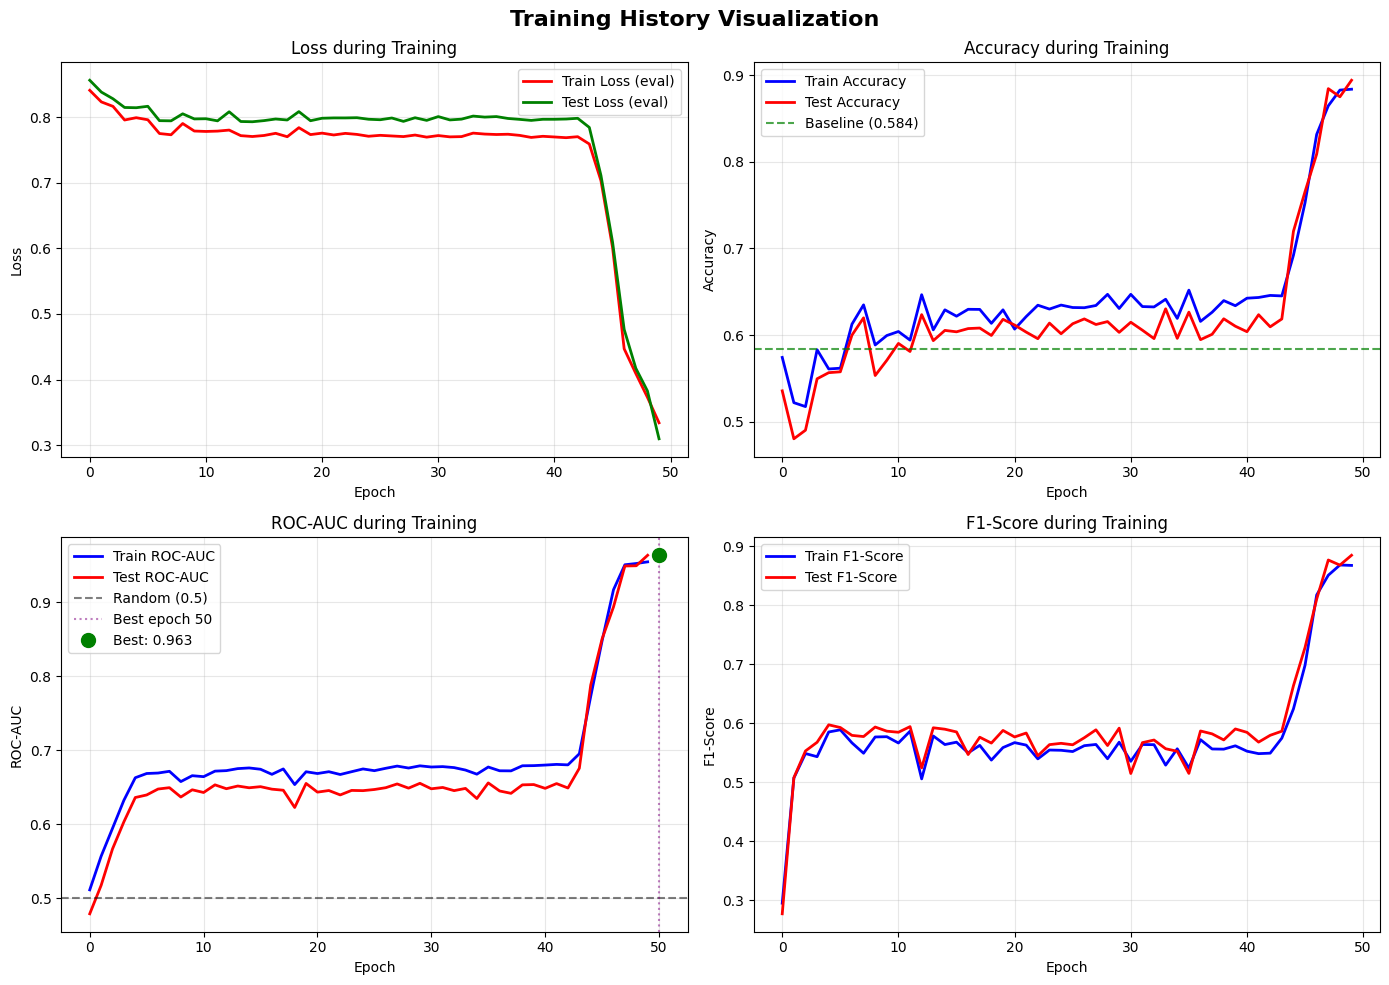

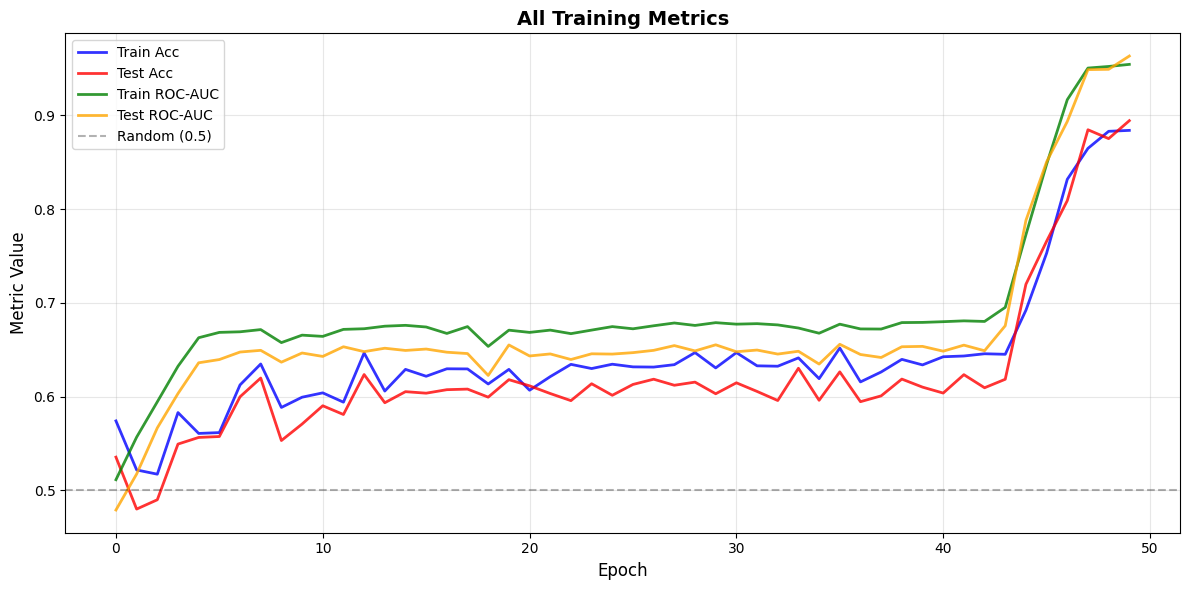

In [11]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

if 'train_loss_history' in locals() and len(train_loss_history) > 0:
    axes[0, 0].plot(train_loss_history, 'r-', linewidth=2, label='Train Loss (eval)')
if 'test_loss_history' in locals() and len(test_loss_history) > 0:
    axes[0, 0].plot(test_loss_history, 'g-', linewidth=2, label='Test Loss (eval)')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss during Training')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

if 'train_acc_history' in locals() and len(train_acc_history) > 0:
    axes[0, 1].plot(train_acc_history, 'b-', linewidth=2, label='Train Accuracy')
if 'test_acc_history' in locals() and len(test_acc_history) > 0:
    axes[0, 1].plot(test_acc_history, 'r-', linewidth=2, label='Test Accuracy')

if 'test_loader' in locals():
    try:
        all_labels = []
        for data in test_loader:
            all_labels.extend(data.edge_label.cpu().numpy())
        if len(all_labels) > 0:
            pos_ratio = np.mean(all_labels)
            baseline = max(pos_ratio, 1-pos_ratio)
            axes[0, 1].axhline(y=baseline, color='g', linestyle='--',
                              label=f'Baseline ({baseline:.3f})', alpha=0.7)
    except:
        pass

axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy during Training')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

if 'train_roc_history' in locals() and len(train_roc_history) > 0:
    axes[1, 0].plot(train_roc_history, 'b-', linewidth=2, label='Train ROC-AUC')
if 'test_roc_history' in locals() and len(test_roc_history) > 0:
    axes[1, 0].plot(test_roc_history, 'r-', linewidth=2, label='Test ROC-AUC')

axes[1, 0].axhline(y=0.5, color='k', linestyle='--', label='Random (0.5)', alpha=0.5)

if 'test_roc_history' in locals() and len(test_roc_history) > 0:
    best_epoch = np.argmax(test_roc_history) + 1
    best_value = test_roc_history[best_epoch - 1]
    axes[1, 0].axvline(x=best_epoch, color='purple', linestyle=':',
                      alpha=0.5, label=f'Best epoch {best_epoch}')
    axes[1, 0].plot(best_epoch, best_value, 'go', markersize=10,
                   label=f'Best: {best_value:.3f}')

axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('ROC-AUC')
axes[1, 0].set_title('ROC-AUC during Training')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

if 'train_f1_history' in locals() and len(train_f1_history) > 0:
    axes[1, 1].plot(train_f1_history, 'b-', linewidth=2, label='Train F1-Score')
if 'test_f1_history' in locals() and len(test_f1_history) > 0:
    axes[1, 1].plot(test_f1_history, 'r-', linewidth=2, label='Test F1-Score')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1-Score')
    axes[1, 1].set_title('F1-Score during Training')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
else:
    if 'train_acc_history' in locals() and 'test_acc_history' in locals():
        if len(train_acc_history) == len(test_acc_history):
            gap = [train - test for train, test in zip(train_acc_history, test_acc_history)]
            axes[1, 1].plot(gap, 'm-', linewidth=2, label='Train-Test Gap')
            axes[1, 1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
            axes[1, 1].set_xlabel('Epoch')
            axes[1, 1].set_ylabel('Accuracy Gap')
            axes[1, 1].set_title('Train-Test Accuracy Gap')
            axes[1, 1].legend()
            axes[1, 1].grid(True, alpha=0.3)

plt.suptitle('Training History Visualization', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

fig2, ax2 = plt.subplots(figsize=(12, 6))

metrics_to_plot = []
if 'train_acc_history' in locals() and len(train_acc_history) > 0:
    metrics_to_plot.append(('Train Acc', train_acc_history, 'blue'))
if 'test_acc_history' in locals() and len(test_acc_history) > 0:
    metrics_to_plot.append(('Test Acc', test_acc_history, 'red'))
if 'train_roc_history' in locals() and len(train_roc_history) > 0:
    metrics_to_plot.append(('Train ROC-AUC', train_roc_history, 'green'))
if 'test_roc_history' in locals() and len(test_roc_history) > 0:
    metrics_to_plot.append(('Test ROC-AUC', test_roc_history, 'orange'))

for label, data, color in metrics_to_plot:
    ax2.plot(data, color=color, linewidth=2, label=label, alpha=0.8)

ax2.axhline(y=0.5, color='k', linestyle='--', alpha=0.3, label='Random (0.5)')

ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Metric Value', fontsize=12)
ax2.set_title('All Training Metrics', fontsize=14, fontweight='bold')
ax2.legend(loc='best')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


--- Входной граф для GNN (только узлы с признаками) ---


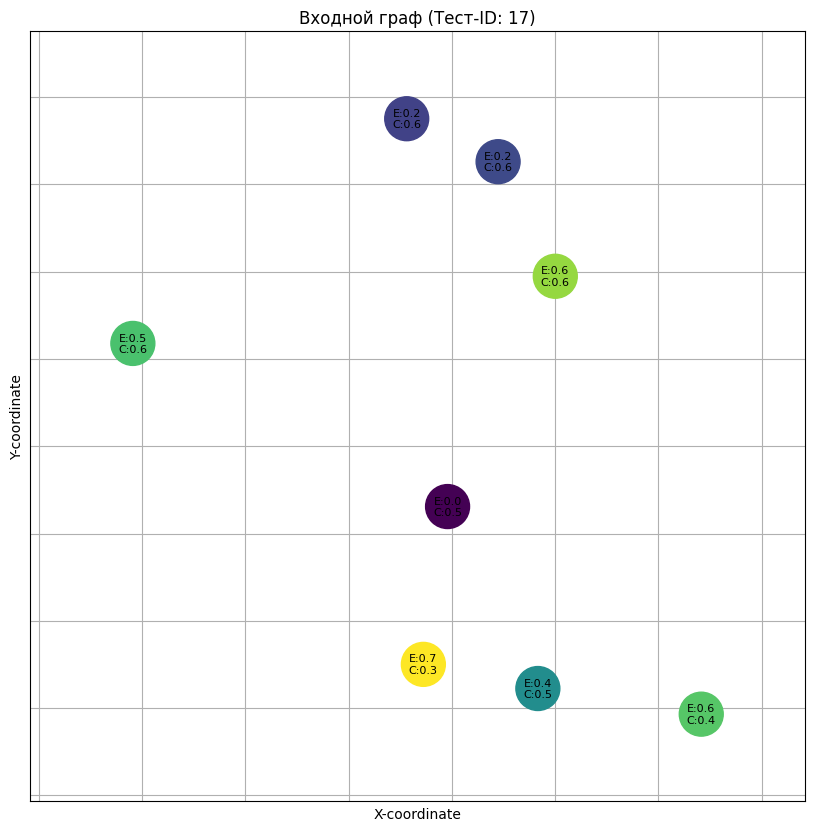


--- Истинная 'оптимальная' топология ---


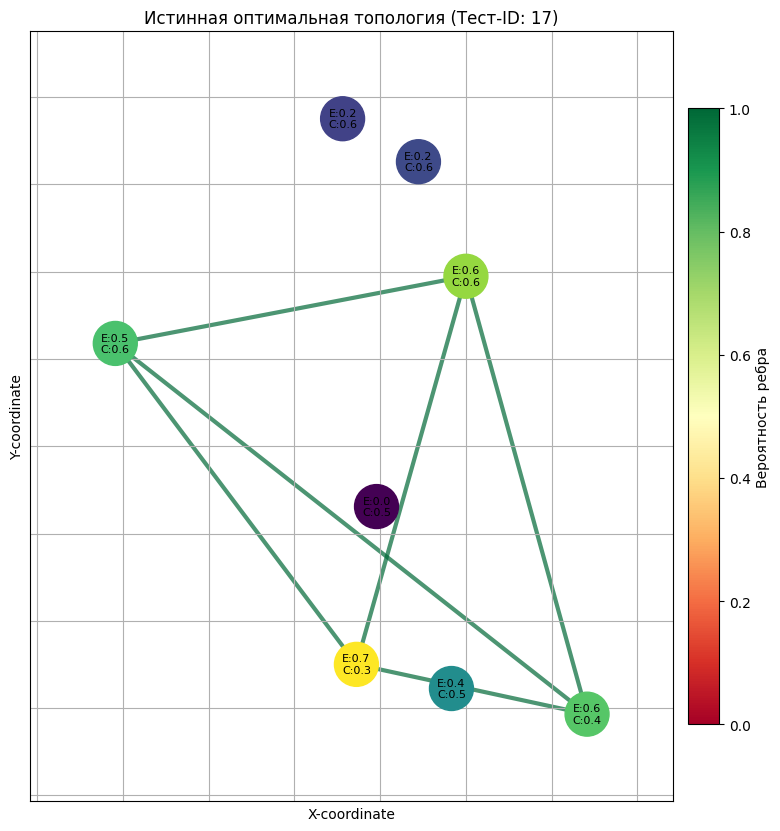


--- Предсказанная GNN 'оптимальная' топология ---
Всего возможных ребер: 56
Средняя вероятность: 0.252
Предсказано положительных ребер (prob > 0.5): 10
Средняя вероятность предсказанных ребер: 0.549


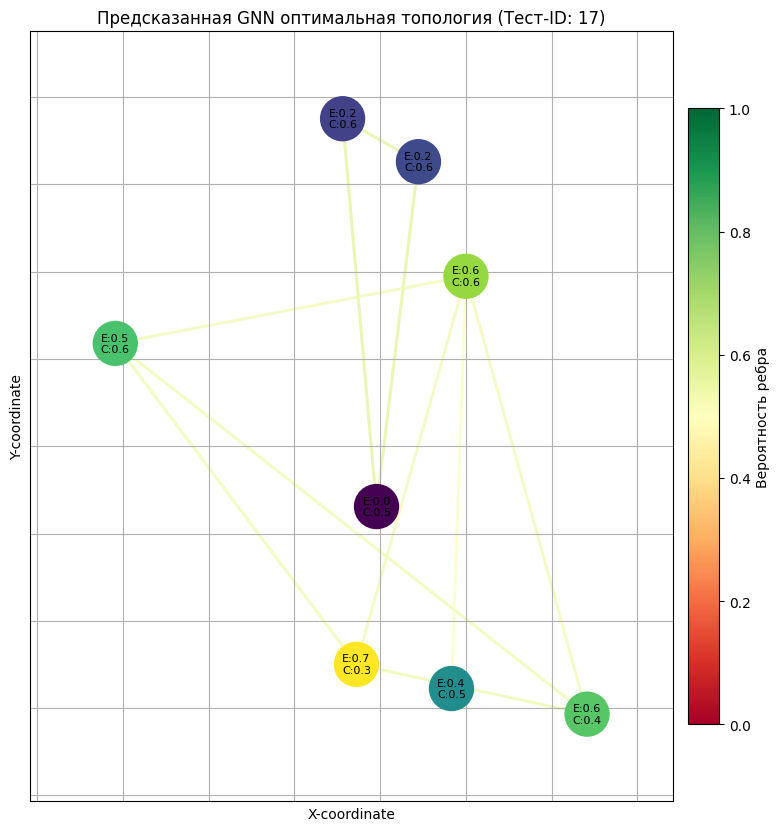


Демонстрация завершена.


In [14]:
def visualize_graph(data_x, edges_to_draw=None, edge_probs=None, title="Graph", feature_map=None):
    """
    Визуализирует граф, используя реальные координаты узлов.

    Args:
        data_x (torch.Tensor): Признаки узлов графа.
        edges_to_draw (list, optional): Список кортежей (u, v) для ребер.
        edge_probs (list, optional): Вероятности для каждого ребра из edges_to_draw.
        title (str): Заголовок графика.
        feature_map (dict, optional): Словарь для отображения признаков узлов в цвета.
    """
    G = nx.Graph()
    num_nodes = data_x.shape[0]

    node_primary_features = data_x[:, 0].squeeze().tolist()

    node_labels_dict = {}
    pos = {}
    for i in range(num_nodes):
        G.add_node(i, features=data_x[i].tolist())
        node_labels_dict[i] = f"E:{data_x[i,0]:.1f}\nC:{data_x[i,1]:.1f}"
        pos[i] = (data_x[i, 2].item(), data_x[i, 3].item())

    min_feat = min(node_primary_features)
    max_feat = max(node_primary_features)
    if max_feat == min_feat:
        node_colors = ['lightblue'] * num_nodes
    else:
        norm_features = [(f - min_feat) / (max_feat - min_feat) for f in node_primary_features]
        cmap = plt.cm.viridis
        node_colors = [cmap(nf) for nf in norm_features]

    if edges_to_draw:
        G.add_edges_from(edges_to_draw)

    fig, ax = plt.subplots(figsize=(10, 10))
    plt.title(title)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=1000, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=node_labels_dict, font_size=8, font_color='black', ax=ax)

    if edges_to_draw:
        if edge_probs is not None and len(edge_probs) == len(edges_to_draw):
            edge_colors = []
            edge_widths = []
            for prob in edge_probs:
                edge_colors.append(plt.cm.RdYlGn(prob))
                edge_widths.append(1 + prob * 2)

            edges = nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw,
                                          edge_color=edge_colors,
                                          width=edge_widths,
                                          alpha=0.7,
                                          ax=ax)

            sm = plt.cm.ScalarMappable(cmap=plt.cm.RdYlGn,
                                      norm=plt.Normalize(vmin=0, vmax=1))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=ax, label='Вероятность ребра',
                              shrink=0.8, pad=0.02)
        else:
            nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw,
                                  edge_color='grey', width=1, alpha=0.7, ax=ax)

    ax.grid(True)
    ax.set_xlabel("X-coordinate")
    ax.set_ylabel("Y-coordinate")
    ax.set_xlim(data_x[:, 2].min().item() - 1, data_x[:, 2].max().item() + 1)
    ax.set_ylim(data_x[:, 3].min().item() - 1, data_x[:, 3].max().item() + 1)

    plt.show()

if len(test_dataset) == 0:
    print("Тестовый набор данных пуст. Невозможно провести демонстрацию.")
else:
    sample_idx = random.randint(0, len(test_dataset) - 1)
    test_graph_data = test_dataset[sample_idx]
    test_graph_data = test_graph_data.to(device)

    print("\n--- Входной граф для GNN (только узлы с признаками) ---")
    visualize_graph(test_graph_data.x.cpu(), title=f"Входной граф (Тест-ID: {sample_idx})")

    print("\n--- Истинная 'оптимальная' топология ---")
    true_optimal_edges_indices = (test_graph_data.edge_label == 1.0).nonzero(as_tuple=True)[0]
    true_optimal_edge_list = []
    true_optimal_probs = []

    for idx in true_optimal_edges_indices:
        u, v = test_graph_data.edge_label_index[0, idx].item(), test_graph_data.edge_label_index[1, idx].item()
        if u < v:
            true_optimal_edge_list.append((u, v))
            true_optimal_probs.append(1.0)

    visualize_graph(test_graph_data.x.cpu(),
                   edges_to_draw=true_optimal_edge_list,
                   edge_probs=true_optimal_probs,
                   title=f"Истинная оптимальная топология (Тест-ID: {sample_idx})")

    print("\n--- Предсказанная GNN 'оптимальная' топология ---")
    model.eval()
    with torch.no_grad():
        pred_logits = model(test_graph_data.x, test_graph_data.edge_index, test_graph_data.edge_label_index)
        pred_probs = torch.sigmoid(pred_logits.squeeze())

        print(f"Всего возможных ребер: {len(pred_probs)}")
        print(f"Средняя вероятность: {pred_probs.mean().item():.3f}")

        predicted_existing_edges_indices = (pred_probs > 0.5).nonzero(as_tuple=True)[0]
        predicted_optimal_edge_list = []
        predicted_optimal_probs = []

        for idx in predicted_existing_edges_indices:
            u, v = test_graph_data.edge_label_index[0, idx].item(), test_graph_data.edge_label_index[1, idx].item()
            if u < v:
                predicted_optimal_edge_list.append((u, v))
                predicted_optimal_probs.append(pred_probs[idx].item())

        print(f"Предсказано положительных ребер (prob > 0.5): {len(predicted_optimal_edge_list)}")
        if len(predicted_optimal_probs) > 0:
            print(f"Средняя вероятность предсказанных ребер: {sum(predicted_optimal_probs)/len(predicted_optimal_probs):.3f}")

    visualize_graph(test_graph_data.x.cpu(),
                   edges_to_draw=predicted_optimal_edge_list,
                   edge_probs=predicted_optimal_probs,
                   title=f"Предсказанная GNN оптимальная топология (Тест-ID: {sample_idx})")



    print("\nДемонстрация завершена.")